In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision

import tensorflow as tf
import random


In [2]:
def convert(df):
    mapping = {
        "yes": 1, "no": 0,
        "high": 2, "low": 1, "none": 0
    }
    
    for col in df.iloc[:, :12].columns:
        df[col] = df[col].map(mapping).fillna(df[col])  # Giữ nguyên giá trị nếu không có trong mapping
    
    return df

In [3]:
cols_to_drop = ['text', 'advanced_text', 'policy', 'antibiotics', 'self_empl', 'days_at_home', 
                'text_hist', 'text_phys_exam', 'advanced_text_hist','advanced_text_phys_exam',
                'phys_emb', 'adv_hist_emb', 'adv_phys_emb',
               ]

### File train 8000
train_df = pd.read_pickle('../../data/train_8000_final.p')
train_df = train_df.drop(columns=cols_to_drop, errors='ignore')  

### File test 2000
test_df = pd.read_pickle('../../data/test_2000_final.p')
test_df = test_df.drop(columns=cols_to_drop, errors='ignore') 

train_df = convert(train_df)
test_df = convert(test_df)

# Tạo nhãn kết hợp từ hai cột pneu và cold
count_values = train_df[['pneu', 'inf']].astype(str).agg('-'.join, axis=1)

# Kiểm tra số lượng mẫu mỗi nhóm nhãn
print(count_values.value_counts())

0-0    6057
0-1    1856
1-0      56
1-1      31
Name: count, dtype: int64


In [4]:
train_df.iloc[:, :12]

,asthma,smoking,COPD,winter,hay_fever,pneu,inf,dysp,cough,pain,fever,nasal
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,0,1,1,0,1
2,0,0,0,1,0,0,1,0,1,0,1,1
3,0,0,0,1,0,0,1,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0,0,0,0,0,0,0,0,0,0,0,0
7996,0,0,0,0,0,0,0,1,0,0,0,0
7997,0,0,0,0,0,0,1,0,0,0,0,1
7998,0,0,0,0,0,0,1,0,1,0,0,1


In [5]:
def NN_model_train(target, df_train, df_test, emb='hist_emb'):
    
    # Chuyển embeddings từ dạng list thành numpy array
    X_train = np.array(df_train.iloc[:, :12].drop(columns=target, errors='ignore'))
    X_test = np.array(df_test.iloc[:, :12].drop(columns=target, errors='ignore'))

    """X_train = np.concatenate([X_train, df_train[emb].tolist()], axis=1)
    X_test = np.concatenate([X_test, df_test[emb].tolist()], axis=1)"""

    y_train = df_train[target].values  # Đảm bảo y_train là numpy array
    y_true = df_test[target].values  

    print("y_train shape:", y_train.shape)
    print("X_train: ", X_train.shape[1])
    # Định nghĩa model
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1, activation='relu')
    ])

    # Chọn loss function
    loss = 'binary_crossentropy'
    model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])
    
    model.summary()

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {0: class_weights[0], 1: class_weights[1]}

    print("Class Weights:", class_weights)

    # Huấn luyện mô hình
    model.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2, class_weight=class_weights)

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)

    # Bước 5: Tính ROC và PR Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

   
    return model, roc_auc, fpr, tpr, recall, precision

y_train shape: (8000,)
X_train:  11


C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9054 - loss: 0.5303 - val_accuracy: 0.9131 - val_loss: 0.3774
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9237 - loss: 0.8448 - val_accuracy: 0.9294 - val_loss: 0.3336
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9214 - loss: 0.8545 - val_accuracy: 0.8856 - val_loss: 0.6663
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9258 - loss: 0.6391 - val_accuracy: 0.9025 - val_loss: 0.5198
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8749 - loss: 0.5585 - val_accuracy: 0.9444 - val_loss: 0.2788
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9511 - loss: 0.5364 - val_accuracy: 0.9394 - val_loss: 0.3146
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9361 - loss: 0.5318 - val_accuracy: 0.9506 - val_loss: 0.2734
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9484 - loss: 0.7784 - val_accuracy: 0.9456 - val_loss: 0.2661
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9217 - loss: 0.3323 - val_accuracy: 0.9625 - val_loss: 0.1861
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9507 - loss: 0.6882 - val_accuracy: 0.9544 - val_loss: 0.2255
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9362 - loss: 0.3247 - val_accuracy: 0.9544 - val_loss: 0.2636
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9432 - loss: 0.2948 - val_accuracy: 0.9538 - val_loss: 0.2471
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9519 - loss: 0.3117 - val_accuracy: 0.9425 - val_loss: 0.2861
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9470 - loss: 0.2869 - val_accuracy: 0.9463 - val_loss: 0.3004
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9094 - loss: 0.4691 - val_accuracy: 0.9312 - val_loss: 0.3173
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8981 - loss: 0.3250 - val_accuracy: 0.9262 - val_loss: 0.3169
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9186 - loss: 0.2653 - val_accuracy: 0.9613 - val_loss: 0.1821
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9324 - loss: 0.2304 - val_accuracy: 0.9481 - val_loss: 0.2314
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9330 - loss: 0.2240 - val_accuracy: 0.9594 - val_loss: 0.2193
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9403 - loss: 0.2106 - val_accuracy: 0.9506 - val_loss: 0.2478
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9397 - loss: 0.2236 - val_accuracy: 0.9694 - val_loss: 0.1306
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9380 - loss: 1.1170 - val_accuracy: 0.9237 - val_loss: 0.2519
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9155 - loss: 0.9194 - val_accuracy: 0.9438 - val_loss: 0.1865
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9326 - loss: 0.8884 - val_accuracy: 0.8056 - val_loss: 0.7782
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8696 - loss: 1.0244 - val_accuracy: 0.9206 - val_loss: 0.3254
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9255 - loss: 0.7757 - val_accuracy: 0.9431 - val_loss: 0.2763
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9294 - loss: 0.7876 - val_accuracy: 0.9244 - val_loss: 0.2448
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9257 - loss: 0.7477 - val_accuracy: 0.9450 - val_loss: 0.2546
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8823 - loss: 1.3845 - val_accuracy: 0.9300 - val_loss: 0.3243
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8997 - loss: 0.4253 - val_accuracy: 0.9225 - val_loss: 0.3385
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9232 - loss: 0.3949 - val_accuracy: 0.9044 - val_loss: 0.4414
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9022 - loss: 0.3694 - val_accuracy: 0.9100 - val_loss: 0.4217
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9044 - loss: 0.3750 - val_accuracy: 0.9056 - val_loss: 0.4259
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8915 - loss: 0.3602 - val_accuracy: 0.9269 - val_loss: 0.2708
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9068 - loss: 0.3566 - val_accuracy: 0.9287 - val_loss: 0.2552
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

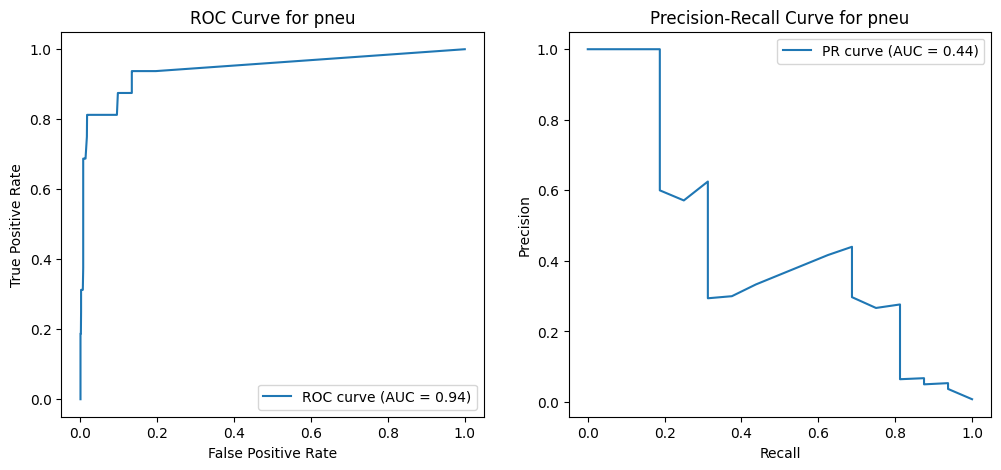

y_train shape: (8000,)
X_train:  11


C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8322 - loss: 0.5649 - val_accuracy: 0.8925 - val_loss: 0.3740
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8975 - loss: 0.3739 - val_accuracy: 0.8900 - val_loss: 0.3901
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8999 - loss: 0.3647 - val_accuracy: 0.8950 - val_loss: 0.3435
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9015 - loss: 0.3556 - val_accuracy: 0.8931 - val_loss: 0.3802
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9029 - loss: 0.3509 - val_accuracy: 0.8988 - val_loss: 0.3382
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9064 - loss: 0.3529 - val_accuracy: 0.8963 - val_loss: 0.3485
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9060 - loss: 0.3484 - val_accuracy: 0.8944 - val_loss: 0.3516
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8276 - loss: 0.5215 - val_accuracy: 0.8925 - val_loss: 0.3661
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8980 - loss: 0.3960 - val_accuracy: 0.8988 - val_loss: 0.3240
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9010 - loss: 0.3879 - val_accuracy: 0.8756 - val_loss: 0.4369
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8991 - loss: 0.3895 - val_accuracy: 0.9000 - val_loss: 0.3542
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8960 - loss: 0.3979 - val_accuracy: 0.8919 - val_loss: 0.2753
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9016 - loss: 0.3355 - val_accuracy: 0.8931 - val_loss: 0.3239
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8996 - loss: 0.3244 - val_accuracy: 0.8969 - val_loss: 0.3159
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8389 - loss: 0.6704 - val_accuracy: 0.8931 - val_loss: 0.2671
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8907 - loss: 0.3779 - val_accuracy: 0.8988 - val_loss: 0.3117
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9028 - loss: 0.4538 - val_accuracy: 0.8731 - val_loss: 0.4000
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8815 - loss: 0.3466 - val_accuracy: 0.8944 - val_loss: 0.2977
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8992 - loss: 0.3091 - val_accuracy: 0.8919 - val_loss: 0.3229
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8957 - loss: 0.3089 - val_accuracy: 0.8919 - val_loss: 0.3130
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8997 - loss: 0.3072 - val_accuracy: 0.8938 - val_loss: 0.3155
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8102 - loss: 0.8169 - val_accuracy: 0.8950 - val_loss: 0.3005
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8934 - loss: 0.3555 - val_accuracy: 0.8988 - val_loss: 0.2785
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8976 - loss: 0.3696 - val_accuracy: 0.8956 - val_loss: 0.3136
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8846 - loss: 0.3522 - val_accuracy: 0.8906 - val_loss: 0.3567
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8925 - loss: 0.3535 - val_accuracy: 0.8888 - val_loss: 0.4207
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8974 - loss: 0.3407 - val_accuracy: 0.8944 - val_loss: 0.3285
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8964 - loss: 0.3903 - val_accuracy: 0.8813 - val_loss: 0.5195
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7932 - loss: 0.6280 - val_accuracy: 0.8938 - val_loss: 0.3133
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8977 - loss: 0.3615 - val_accuracy: 0.8900 - val_loss: 0.3665
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8907 - loss: 0.3552 - val_accuracy: 0.8900 - val_loss: 0.3512
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8941 - loss: 0.3463 - val_accuracy: 0.8963 - val_loss: 0.3192
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8985 - loss: 0.3442 - val_accuracy: 0.8950 - val_loss: 0.3251
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8991 - loss: 0.3432 - val_accuracy: 0.8950 - val_loss: 0.3202
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8996 - loss: 0.3427 - val_accuracy: 0.8969 - val_loss: 0.3199
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

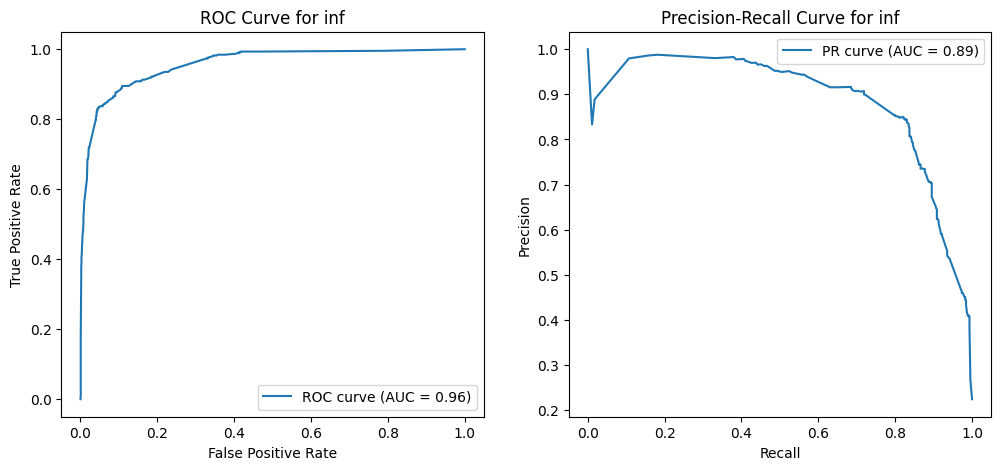

In [6]:
seeds = [327, 100, 105, 888, 521]
targets = ["pneu", "inf"]

best_models = {}

for target in targets:
    best_auc = -1
    best_model = None
    best_fpr = best_tpr = best_recall = best_precision = None

    for seed in seeds:
        np.random.seed(seed)
        random.seed(seed)
        tf.random.set_seed(seed)

        model, auc_score, fpr, tpr, recall, precision = NN_model_train(target, train_df, test_df)

        if auc_score > best_auc:
            best_auc = auc_score
            best_model = model
            best_fpr = fpr
            best_tpr = tpr
            best_recall = recall
            best_precision = precision

    # Lưu mô hình tốt nhất
    best_models[target] = best_model
    print(f"Best model for '{target}' has ROC AUC = {best_auc:.4f}")

    # Chỉ vẽ đồ thị cho mô hình tốt nhất
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(best_fpr, best_tpr, label=f"ROC curve (AUC = {best_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for " + target)
    plt.legend()

    plt.subplot(1, 2, 2)
    pr_auc = auc(best_recall, best_precision)
    plt.plot(best_recall, best_precision, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for " + target)
    plt.legend()

    plt.show()
